ERROR:yfinance:$BRK.B: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching price for BRK.B: single positional indexer is out-of-bounds
    Stock  Expiration  Underlying  Strike   Call    Put  Time_to_Exp(yrs)  \
0    AAPL  2025-04-11  203.190002   202.5   6.03   5.40             0.016   
1    AAPL  2025-04-17  203.190002   202.5   7.30   6.56             0.033   
2    AAPL  2025-04-25  203.190002   205.0   7.40   8.74             0.055   
3    AAPL  2025-05-02  203.190002   205.0   9.15  10.01             0.074   
4    AAPL  2025-05-09  203.190002   200.0  12.25   8.55             0.093   
..    ...         ...         ...     ...    ...    ...               ...   
164   JPM  2026-03-20  228.690002   230.0  26.50  23.95             0.956   
165   JPM  2026-06-18  228.690002   230.0  29.21  26.30             1.203   
166   JPM  2026-12-18  228.690002   230.0  33.68  30.60             1.704   
167   JPM  2027-01-15  228.690002   230.0  34.70  30.62             1.781   
168   JPM  2027-12-17  228.690002   230.0  41.25  34.20             2.701   



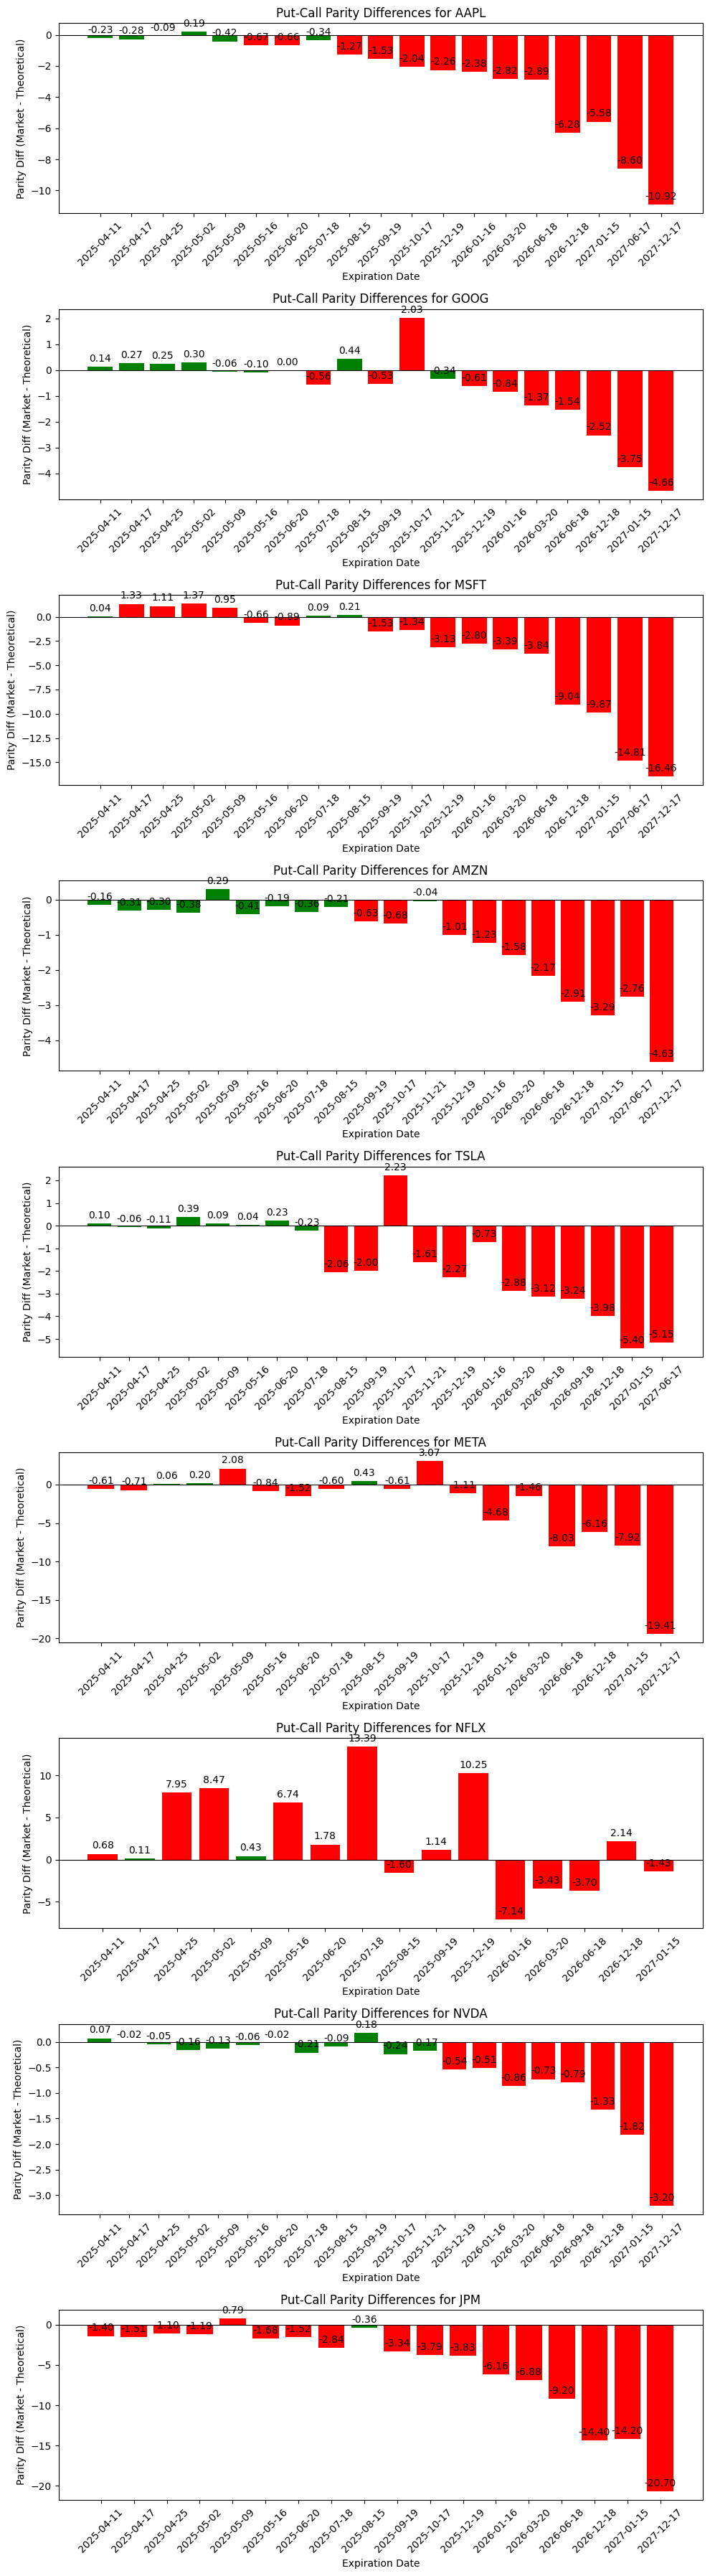

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Set risk-free rate (annualized) and arbitrage threshold (in dollars)
r = 0.05
arbitrage_threshold = 0.5

# List of 10 stocks (adjust as needed; updated "FB" -> "META", etc.)
stocks = ["AAPL", "GOOG", "MSFT", "AMZN", "TSLA", "META", "NFLX", "NVDA", "BRK.B", "JPM"]

results = []

for ticker_symbol in stocks:
    ticker = yf.Ticker(ticker_symbol)

    # Get current underlying price (most recent close)
    try:
        hist = ticker.history(period="1d")
        S = hist["Close"].iloc[-1]
    except Exception as e:
        print(f"Error fetching price for {ticker_symbol}: {e}")
        continue

    # Get list of available expiration dates for options
    expirations = ticker.options
    if not expirations:
        print(f"No option data for {ticker_symbol}")
        continue

    # Filter out past expirations
    valid_expirations = [
        e for e in expirations
        if datetime.strptime(e, "%Y-%m-%d") > datetime.today()
    ]
    if not valid_expirations:
        print(f"No valid future expiration date for {ticker_symbol}")
        continue

    # Loop over all valid expiration dates for the current stock
    for exp in valid_expirations:
        exp_date = datetime.strptime(exp, "%Y-%m-%d")
        today = datetime.today()
        T = (exp_date - today).days / 365.0  # time to expiration in years

        try:
            opt_chain = ticker.option_chain(exp)
        except Exception as e:
            print(f"Error fetching option chain for {ticker_symbol} on {exp}: {e}")
            continue

        calls = opt_chain.calls.copy()
        puts = opt_chain.puts.copy()

        if calls.empty or puts.empty:
            print(f"No calls or puts data for {ticker_symbol} on {exp}")
            continue

        # Identify the strike price closest to the underlying price S
        calls["diff"] = abs(calls["strike"] - S)
        closest_call_idx = calls["diff"].idxmin()
        if pd.isna(closest_call_idx):
            print(f"No ATM call found for {ticker_symbol} on {exp}")
            continue
        closest_call = calls.loc[closest_call_idx]
        strike = closest_call["strike"]
        call_price = closest_call["lastPrice"]

        # Find the corresponding put option for the same strike
        put_row = puts[puts["strike"] == strike]
        if put_row.empty:
            print(f"No matching put for strike {strike} for {ticker_symbol} on {exp}")
            continue
        put_price = put_row.iloc[0]["lastPrice"]

        # Calculate put-call parity
        # Theoretical: S - K * exp(-rT)
        theoretical_diff = S - strike * np.exp(-r * T)
        # Market observed: call - put
        market_diff = call_price - put_price
        # Deviation
        parity_diff = market_diff - theoretical_diff

        # Arbitrage check
        arbitrage_signal = "Arbitrage Opportunity" if abs(parity_diff) > arbitrage_threshold else "No Arbitrage"

        results.append({
            "Stock": ticker_symbol,
            "Expiration": exp,
            "Underlying": S,
            "Strike": strike,
            "Call": call_price,
            "Put": put_price,
            "Time_to_Exp(yrs)": round(T, 3),
            "Theoretical": round(theoretical_diff, 2),
            "Market": round(market_diff, 2),
            "Parity_Diff": round(parity_diff, 2),
            "Arbitrage": arbitrage_signal
        })

# Create a DataFrame from the results
df = pd.DataFrame(results)
print(df)

# -------------------------------------------------------
# EXPORT RESULTS TO CSV FOR EXAMINATION IN EXCEL
# -------------------------------------------------------
csv_filename = "put_call_parity_results.csv"
df.to_csv(csv_filename, index=False)
print(f"\nResults have been exported to '{csv_filename}'")

# If the DataFrame is empty, stop
if df.empty:
    print("No valid data to plot. All symbols were skipped.")
else:
    # Convert Expiration to datetime format for plotting
    df["Expiration"] = pd.to_datetime(df["Expiration"])
    unique_stocks = df["Stock"].unique()

    # Create a subplot for each stock
    num_stocks = len(unique_stocks)
    fig, axes = plt.subplots(num_stocks, 1, figsize=(10, 4*num_stocks), squeeze=False)

    for idx, stock in enumerate(unique_stocks):
        sub_df = df[df["Stock"] == stock].sort_values("Expiration")
        ax = axes[idx, 0]
        # Use different colors based on the arbitrage threshold
        colors = ["red" if abs(val) > arbitrage_threshold else "green" for val in sub_df["Parity_Diff"]]
        bars = ax.bar(sub_df["Expiration"].dt.strftime('%Y-%m-%d'), sub_df["Parity_Diff"], color=colors)
        ax.axhline(0, color='black', linewidth=0.8)
        ax.set_title(f"Put-Call Parity Differences for {stock}")
        ax.set_xlabel("Expiration Date")
        ax.set_ylabel("Parity Diff (Market - Theoretical)")
        ax.tick_params(axis='x', rotation=45)
        # Annotate each bar with the parity difference value
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
